# Analyse des EMD


In [46]:
## Chargement du module R (à exécuter une et une seule fois) ##

%load_ext rpy2.ipython

## Préalable


On va mêler ici code **Python** et code **R**. 

Pour se faire, on utilise la commande `%%R` afin de définir une cellule magique.  

_Attention, les variables utilisées dans chacun des langages restent privées pour chacun des langages. Il n'est pas possible de disposer d'une variable définie en R sous Python et réciproquement._


## Pour Google Colab

### Installation de Miniconda et importation des packages `R` depuis Conda

In [ ]:
####
## !!! À utiliser uniquement dans la cadre de GOOGLE COLAB !!!
## Sinon sauter directement à `Chargement des données`
####


!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
# Append path to be able to run packages installed with conda
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
# Install packages from Anaconda
!conda install -c r r-essentials
!conda install -c r r-plyr
!conda install -c r r-scales
!conda install -c conda-forge r-readr
!conda install -c conda-forge r-circlize
!conda install -c conda-forge r-cowplot
!conda install -c bioconda r-clvalid
!conda install -c conda-forge r-party
!conda install -c conda-forge r-rpart.plot
!conda install -c r r-dplyr

### Importation des données depuis Drive

In [ ]:
from google.colab import drive
from google.colab import files
import shutil
drive.mount('/content/drive')

#files.download('/content/drive/My Drive/Data.zip')
#files.download('/content/drive/My Drive/Flows.zip')

shutil.copy("/content/drive/My Drive/Data.zip","/content/Data.zip")
shutil.copy("/content/drive/My Drive/Flows.zip","/content/Flows.zip")
!unzip Data.zip -d /content
!unzip Flows.zip -d /content

## Fin colab

### Chargement des données

In [47]:
%%R

library(scales)
library(readr)
library(plyr)
library(dplyr)
library(circlize)
library(ggplot2)
library(cowplot)
library(cluster)
library(clValid)
library(rpart)
library(rpart.plot)

emd <- read.csv("Data/sequences_emd.csv", sep = ";")

R[write to console]: 
Attachement du package : ‘readr’


R[write to console]: The following object is masked from ‘package:scales’:

    col_factor


R[write to console]: 
Attachement du package : ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ========================================
circlize version 0.4.8
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: http://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization 
  in R. Bioinformatics 2014.


R[write to console]: 
**

In [4]:
import pandas as pd
import numpy as np
import re
from itertools import groupby
from pynauty import *
import plotly.graph_objects as go

emd = pd.read_csv("Data/sequences_emd.csv", sep=";")

# Listes des séquences sémantiques
seq_emd = []
seq_emd_agg = []
seq_i = []
seq_i_agg = []
buff_name = emd['id_seq'][0]

for index, row in emd.iterrows():
    if (row['id_seq'] != buff_name):
        seq_emd.append(seq_i)
        seq_emd_agg.append(seq_i_agg)
        buff_name =  row['id_seq']
        seq_i = []
        seq_i_agg = []
    seq_i.append(row['activity'])
    seq_i_agg.append(row['activity_agg'])
seq_emd_agg.append(seq_i_agg)
seq_emd.append(seq_i)

### Fonctions préalables

In [50]:
%%R

#Retourne la couleur associée à une activité a

col_emd <- function(a) {
    if(a %in% c(1, 2, "Act: home")) {
        return("#FBD54A")
    }
     if(a %in% c(11, 12, 13, 81, 43, "Act: work")) {
        return("#9B5097")
    }
     if(a %in% c(30, 31, 32, 33, 34, 35,  "Act: shop")) {
        return("#307876")
    }
     if(a %in% c(21, 22, 23, 24, 25, 26, 27, 28, 29, "Act: study")) {
        return("#3E3DA6")
    }
     if(a %in% c(41, 42, "Act: other")) {
        return("#EF6136")
    }
     if(a %in% c(51, 52, 53, 54, 82, "Act: leasure")) {
        return("#E35090")
    }
     if(a %in% c(61, 62, 63, 64, 71, 72, 73, 74, "Act: commute")) {
        return("#C92F31")
    }
     if(a %in% c(91, "Act: ?")) {
        return("#2A77AA")
    }
    
    ## Modes de transport ##
    if(a %in% c(113, 114, 115, 116, 121, 122, 161, 171, 181, 182, "Move: car")) {
        return("#546776")
    }
      if(a %in% c(100, 110, 111, 112,193, 194, 195, "Move: smooth")) {
        return("#C0C0C0")
    }
      if(a %in% c(191, 192, 196,"Move: other")) {
        return("#797979")
    }
      if(a %in% c(151, 131, 133, 138, 139, 141, 142, "Move: public")) {
        return("#7E9BB5")
    }
     else {
        return("#000000")
    }
}

## Obtention de la moyenne de l'écart-type de `varname` group by `groupnames` ##
data_summary <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE))
  }
  data_sum <- ddply(data, groupnames, .fun=summary_func,
                  varname)
  data_sum <- plyr::rename(data_sum, c("mean" = varname))
 return(data_sum)
}

## Normalisation de l'affichage du clustering hierarchique 

norm_aff_clust <- function(hc, groups) {
    
    ## AJOUT DE L'ID DES CLUSTERS AUX SÉQUENCES ##
    orderClust <- paste("X", hc$order, sep = "")
    id_seq <- names(groups)
    num_clust <- groups[1:length(groups)]
    id_clust <- rep(0, length(groups)) # Organisation selon le dendogramme
    df_groups <- data.frame(id_seq, num_clust, id_clust)
    
    #Réarrangement des ID
    i <- 1
    clust_prop <- data.frame(table(groups))
    for(k in seq(max(num_clust))) {
        c <- df_groups[df_groups$id_seq == orderClust[i], ]$num_clust
        df_groups[df_groups$num_clust == c, ]$id_clust <- k
        i <- i + clust_prop[clust_prop$groups == c, ]$Freq
    }
    
    df_groups <- df_groups[,-2]
    groups[1:length(groups)] <- df_groups$id_clust
    return(groups)
}

## Coupure du dendrogramme selon le saut d'inertie maximal
## Sous contrainte d'au moins `min_clust` clusters et au max `max_clust`
best_cut <- function(hc, min_clust, max_clust) {  
    inertie <- sort(hc$height, decreasing = TRUE)
    #plot(inertie[1:nrow(ced_emd)], type = "s", xlab = "Nombre de classes", ylab = "Inertie")
    ecart <- c()
    for(i in seq(length(inertie) - 1)) {
        ecart <- c(ecart, inertie[i-1] - inertie[i])
    }
    return(which.max(ecart[min_clust:max_clust]) + min_clust)
}



# Couleurs de l'université
univ <- "#47A79F" 
univ2 <- "#424A54" 

# Liste de couleurs des clusters
clusters_col <- c("#1D4A49", "#061663", "#2A6967", "#3F3E7C", "#47A79F", "#7579A2", "#A6D5C2",
                  "#CCCCFB", "#212121", "#666666", "#94989F")

## Sommaire

 [1 - Analyse statistiques](#1)

> [1.1 Fréquence des activités](#1-1)
>
> [1.2 Analyse des séquences d'activités](#1-2)
>>
>> [1.2.1 Distribution des tailles](#1-2-1)
>>
>> [1.2.2 Régularité des séquences](#1-2-2)
>>
> [1.3 Fouille de schémas fréquents](#1-3)
>
> [1.4 Statistiques temporelles](#1-4)
>
> [1.5 Diagramme de flots](#1-5)
>
> [1.6 Entropies](#1-6)

[2 - Clustering hiérarchique](#2)
>
> [2.1 Création du dendrogramme](#2-1)
>
> [2.2 Entropie des clusters](#2-2)
>
> [2.3 Fréquences des activités dans les clusters](#2-3)
>>
>> [2.3.1 Graphique à barres](#2-3-1)
>>
>> [2.3.2 Diagramme Mosaïque](#2-3-2)
>>
>> [2.3.3 Résidus de Pearson et inférences statistiques](#2-3-3)
>>
> [2.4 Régularité des clusters](#2-4)
>
> [2.5 Flots des clusters](#2-5)
>
> [2.6 Extraction des medoids, mode et diametre des clusters](#2-6)
>
> [2.7 Histogramme des distances dans les clusters](#2-7)
>
> [2.8 Schémas fréquents des clusters](#2-8)
>
> [2.9 Extraction des règles des clusters par arbre de décision](#2-9)

# 1 - Analyse statistiques <a class="anchor" id="1"></a>

On dresse ici en préalable un ensemble d'études statistiques communes pour l'analyse des déplacements urbains dans un le cadre de modélisation de la Time Geography. 

Jiang et al. répertorie également la plupart de ces indicateurs dans [The TimeGeo modeling framework for urban mobility without travel surveys](https://www.pnas.org/content/113/37/E5370), PNAS (2016)

À noter que certaines explications physiques des comportements observés pourront être trouvées dans Barthelemy [The Statistical Physics of Cities](https://www.nature.com/articles/s42254-019-0054-2), Nature Review (2019).

## 1.1 Fréquence des activités <a class="anchor" id="1-1"></a>

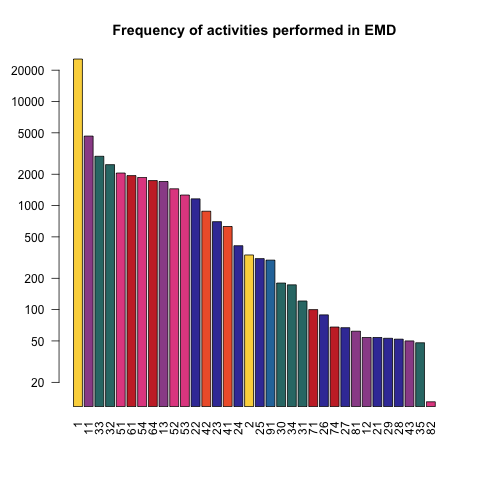

In [4]:
%%R

# On récupère les activités dans un dataFrame
freq_act <- as.data.frame(table(subset(emd, activity < 100)$activity))
colnames(freq_act) <- c("activity","freq")

# Tri par ordre décroissant pour affichage
freq_act <- freq_act[order(-freq_act$freq), ]


# Exportation en PDF ? 
#pdf("barplot_activity.pdf", width = 11, height = 8 )

barplot(names.arg = freq_act[,1], freq_act[,2],
        col = unlist(lapply(freq_act[,1], col_emd)), # Coloration des activités
        log = "y", # Echelle logarithmique
        las = 2,  
        main = "Frequency of activities performed in EMD")

On peut facilement estimer que la fréquence des activités pratiquées suit une [loi de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law). 

Cette loi statistique fait partie de la famille des <i>lois Puissance</i> et indique, en substance, que <i>la fréquence d'un terme est inversement proportionnelle à son rang</i> dans la table des fréquences.

En lien avec notre étude, on trouvera l'article de Song et al., [Modelling the scaling properties of human mobility](https://www.nature.com/articles/nphys1760), Nature Physics (2010) qui montre que la visite des $k$ lieux les plus fréquemment visités suit une loi de Zipf. 

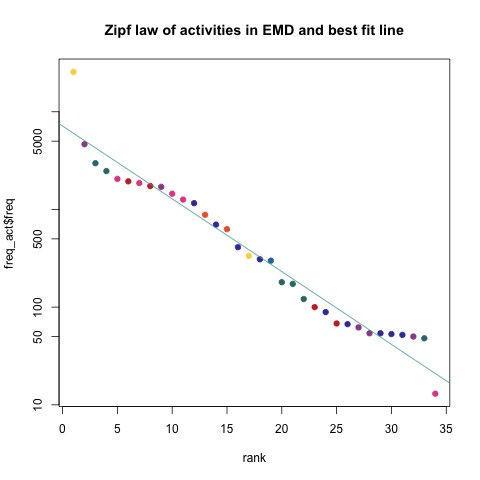

In [5]:
%%R

rank <- seq(1,length(freq_act$freq))

plot(x = rank, 
     y = freq_act$freq, 
     col = unlist(lapply(freq_act[,1], col_emd)),
     pch = 19,
     log = "y",
     main = "Zipf law of activities in EMD and best fit line")

# Droite de régression 
line <- lm(log10(freq_act$freq) ~ rank)
abline(line, col=univ)

On peut effectuer une étude similaire sur les modes de transport. On observe le même phénomène Zipfien que précédemment pour les activités. 

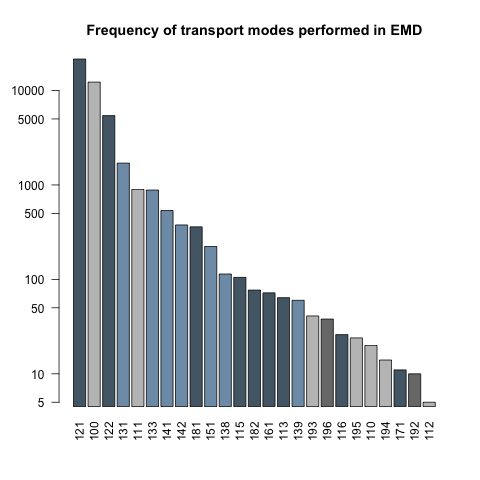

In [6]:
%%R

# On récupère les modes de déplacent dans un dataFrame
freq_tsp <- as.data.frame(table(subset(emd, activity >= 100)$activity))
colnames(freq_tsp) <- c("activity","freq")

# On trie les valeurs
freq_tsp <- freq_tsp[order(-freq_tsp$freq),]

barplot(names.arg = freq_tsp[,1], freq_tsp[,2],
        col = unlist(lapply(freq_tsp[,1], col_emd)),
        log="y",
        las=2, 
        main = "Frequency of transport modes performed in EMD")

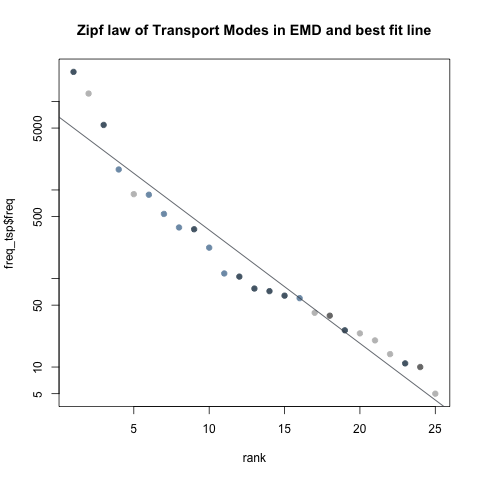

In [7]:
%%R 

rank <- seq(1,length(freq_tsp$freq))

plot(x = rank, 
     y = freq_tsp$freq, 
     col = unlist(lapply(freq_tsp[,1], col_emd)),
     pch = 19,
     log = "y",
     main = "Zipf law of Transport Modes in EMD and best fit line")

# Droite de régression 
line <- lm(log10(freq_tsp$freq) ~ rank)
abline(line, col = univ2)

## 1.2 Analyse des séquences d'activités <a class="anchor" id="1-2"></a>

### 1.2.1 Distribution des tailles <a class="anchor" id="1-2-1"></a>

On souhaite analyser la taille $|S|$ des séquences d'activités issues de l'EMD. 
Pour se faire, on dresse l'histogramme.

On précise que $S$ inclut les modes de transport dans cette étude. 

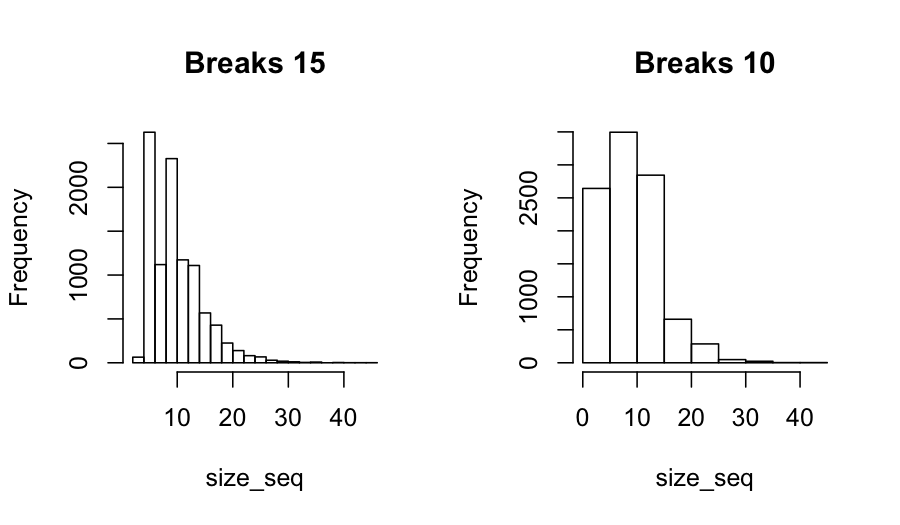

In [8]:
%%R -w 6 -h 3.5 --units in -r 150
par(mfrow = c(1,2))

size_seq <- as.numeric(table(emd$id_seq)) 

## Histogramme 1
hist(size_seq, 
      breaks = 15,
      main = "Breaks 15")

## Histogramme 2
hist(size_seq, 
      breaks = 10,
      main = "Breaks 10")

On peut observer que la taille des séquences semble suivre une loi Gamma, voire de Poisson si l'on augmente la largeur des classes. Jiang et al., [Activity-Based Human Mobility Patterns Inferred from Mobile Phone Data](http://scholar.google.fr/scholar_url?url=https://dspace.mit.edu/bitstream/handle/1721.1/120769/ieee-tbd-2015-12-0163_author_version.pdf%3Fsequence%3D1%26isAllowed%3Dy&hl=fr&sa=X&scisig=AAGBfm1-o-6xPSlq-mf62HH1jsCV_nu4dw&nossl=1&oi=scholarr), IEEE Trans. on Big Data (2017)

Dans notre cas, on a $ 2 \leq  |S| \leq 43$.

On peut remarquer que les séquences $S$ telles que $|S| \equiv 0\ \text{mod } 2$ sont faiblement représentées. 

Cela peut s'expliquer par un contexte de déplacement suivant le paradigme STOP-MOVE Spaccapietra et al. [A Conceptual View on Trajectories](https://www.sciencedirect.com/science/article/abs/pii/S0169023X07002078), Data & Knowledge Engineering (2008). Ainsi, on a une alternance des activités fixes `(id < 100)` et des modes de déplacement `(id >= 100)`. 

Ainsi, lors de l'ajout d'une activité fixe $a_{i+1}$, dans la très grande majorité des cas, on va ajouter 2 nouveaux modes de déplacement tels que $m_i, a_{i+1}, m_{i+1}$. 

Dès lors, on voit que suivant ce paradigme, l'ajout d'une activité produit en réalité 3 items sémantiques.

On va ainsi créer des classes $C_k$ correspondant à des intervalles de 4 items sémantiques : 3 qui correspondent à l'ajout d'une activité fixe et 1 qui résulte des séquences de taille paire. 

$$|S| \in C_k \Leftrightarrow \left\lfloor \frac{|S|-|S|_{\min}}{4}\right\rfloor  + 1 = k$$

In [9]:
%%R 

# Contruction des classes d'intervalles
build_classes <- function(seq, S_min, S_max, pas) {
    classes <- rep(0, S_max / pas)
    for(s in seq) {
        if(s > S_max) {
            classes[length(classes)] <- classes[length(classes)] + 1
        } else {
            k <- (s - S_min) / pas + 1
            classes[k] <- classes[k] + 1
        }
    } 
    return(classes)
}

Ainsi, les $k$ classes représentées sont de la forme : $$C_k = \left [4k + |S|_\min, 4k + |S|_\min + 3 \right] | k \in \mathbb N$$

Où $|S|_\min$ est la taille minimale des séquences sémantiques Ici $|S|_\min = 2$.

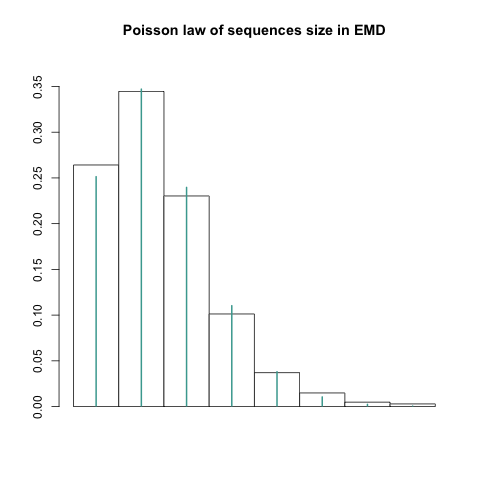

In [10]:
%%R

# Discretisation par tranches de 4 éléments
classes <- build_classes(size_seq, 2, 32, 4)

# Nombre total de séquences
nb_seq <- sum(classes)

# Estimateur maximum de vraissemblance -- Loi de Poisson
lambda <- sum((seq(length(classes))-1) * classes)/nb_seq

# Fonction de masse
poisson <- function(lambda, x) {
    return(lambda^(x-1)/factorial(x-1) * exp(-lambda))
}

#pdf("size_seq-poissonian_law.pdf", width = 7, height = 7 )

barplot(classes / nb_seq,
        col = "white",
        ylim=c(0, 0.38),
        space= c(0.5, rep(0, 7)), 
        main = "Poisson law of sequences size in EMD")

points(x = 1:8,
       y = poisson(lambda,1:8),
       type="h",
       lwd=2,
       col="#47A79F")

### 1.2.2 Régularité des séquences <a class="anchor" id="1-2-2"></a>

Dans Texeira et al., [Deciphering Predictability Limits in Human Mobility](https://dl.acm.org/doi/abs/10.1145/3347146.3359093), ACM SIGSPATIAL (2019) les auteurs s'intéressent à quelques indicateurs permettant de quantifier la prédictibilité de la mobilité humaine. 

Parmi ceux présentés, la _régularité_ d'une séquence $S$ est définie comme le rapport de la taille de la séquence $|S|$ sur le nombre d'activités distinctes $\delta(S)$ pratiquées dans celle-ci : $$reg(S) = \frac{|S|}{\delta(S)}$$

In [13]:
#############################################
## CONSTRUCTION DU FICHIER DES RÉGULARITÉS ##
#############################################

df_reg = pd.DataFrame()

# Colonnes de `df_reg`
reg_col = [[], [], []]

def delta(S):
    return len(set(S))

def append_col(col, values):
    for i in range(len(col)): 
        col[i].append(values[i])
    return col

i = 1
for S in seq_emd : 
    reg_col = append_col(reg_col, ["X"+str(i), delta(S), len(S)])
    i += 1

df_reg["id_seq"] = reg_col[0]
df_reg["delta_S"] = reg_col[1]
df_reg["len_S"] = reg_col[2]
df_reg["reg_S"] = [reg_col[2][i] / reg_col[1][i] for i in range(len(reg_col[2]))]

print(df_reg)

#df_reg.to_csv(r"regularity.csv", index=False)

       id_seq  delta_S  len_S     reg_S
0          X1        3      5  1.666667
1          X2        4      9  2.250000
2          X3        4     17  4.250000
3          X4        3      5  1.666667
4          X5        3      5  1.666667
...       ...      ...    ...       ...
10000  X10001        3      5  1.666667
10001  X10002        3      5  1.666667
10002  X10003        3      5  1.666667
10003  X10004        4      9  2.250000
10004  X10005        7     21  3.000000

[10005 rows x 4 columns]


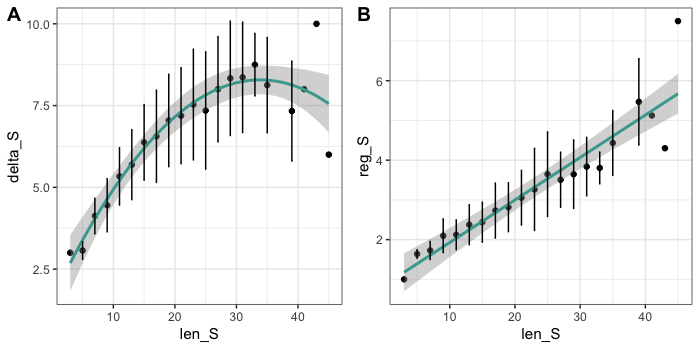

In [14]:
%%R -w 7 -h 3.5 --units in -r 100


# Données de régularité (voir fonction python ci-dessus)
reg <- read.csv("Data/regularity.csv", sep = ",")

# On conserve les séquences pertinentes
reg <- subset(reg, len_S %% 2 == 1)

# Calcul des moyennes et écarts-types
delta_summary <- data_summary(reg, varname="delta_S", groupnames=c("len_S"))

# Graphique des delta(S)
delta_graph <- ggplot(delta_summary, aes(x=len_S, y=delta_S)) + 
               geom_point() +
               geom_smooth(col = univ, method = "lm", formula = y ~ poly(x, 2)) +
               geom_errorbar(aes(ymin=delta_S - sd, ymax= delta_S + sd), width=.2,
                             position=position_dodge(0.05))+
               theme_bw()


###

reg_summary <- data_summary(reg, varname="reg_S", groupnames=c("len_S"))

# Graphique des reg(S)
reg_graph <- ggplot(reg_summary, aes(x=len_S, y=reg_S)) + 
             geom_point() +
             geom_smooth(col = univ, method = "lm") +
             geom_errorbar(aes(ymin=reg_S - sd, ymax= reg_S + sd), width=.2,
                           position=position_dodge(0.05))+
             theme_bw()


plot_grid(delta_graph, reg_graph, labels=c("A", "B"), ncol = 2, nrow = 1)

Le graphique **A** montre le $\delta(S)$ moyen en fonction de $|S|$. On voit que ce nombre semble se stabiliser lorsque $S \rightarrow \infty$. 

En outre, on peut montrer que $\delta(S)$ suit une loi de probabilité géométrique. Pour s'en convaicre, on peut dresser son histogramme de la même façon que fait précédemment avec la taille des séquences. 

Le graphique **B** indique la régularité $reg(S)$ moyenne en fonction de $S$. On constate que les points sont parfaitement alignés selon la droite d'estimation $y = 1.08+0.09x$. 
Plus le coefficient directeur est faible, plus cela indique que les activités sont répétées. 

Avec un coefficient directeur $a$ de $\approx 0.1$, on voit ici que les activités pratiquées au sein des séquences sémantiques sont fréquemment répetées.

En outre, on peut démontrer (en cours...) que pour $S \rightarrow \infty, \delta(S) \approx \frac{1}{a} \approx 10$.

## 1.3 Fouille de schémas fréquents <a class="anchor" id="1-3"></a>

Comme on l'a vu précédemment, les répétitions d'activités sont très fréquentes au sein des séquences sémantiques. 

Dès lors, il peut être intéressant de s'intéresser à la topologie que forme le graphe d'activités d'une séquence  sémantique, c'est-à-dire les lien de précédence et de succession des activités Schneider et al., [Unravelling individual daily mobility motifs](https://royalsocietypublishing.org/doi/10.1098/rsif.2013.0246), Journal of the Royal Society Interface (2013).
Ceci permet entre autres d'observer : 
- Les relations entre les activités et notion de précédence. 
- Les répétitions cycliques d'activités (ou $k$-cycle) et les oscillations (2-cycle)
- L'activité centrale d'une séquence (noeud de degré maximal)
- etc. 

D'un point de vue formel, cela revient à déterminer l'automate reconnaissant le langage d'un ensemble de séquences sémantiques. 

Une autre façon de faire est de représenter les activités d'une séquence sémantique sous la forme d'un graphe orienté $G_S=(N, A)$ où $N = \delta(S)$ et $A = (a_i, a_{i+1})$.

On considère alors  $\mathcal{G} = \{G_S | S \in \mathcal{S}\}$ l'ensemble des graphes formés.  

On construit alors une partition $P = (P_1, ..., P_m)$ de $\mathcal{G}$, telle que $\forall G, G'\in P_i , G \neq G', \exists \varphi$ un [isomorphisme](https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_l%27isomorphisme_de_graphes) tel que $G = \varphi(G')$. 

La recherche de l'isomorphisme $\varphi$ est assurée par l'algorithme Nauty McKay et al. [Practical Graph Isomorphism, II](https://www.sciencedirect.com/science/article/pii/S0747717113001193), J. Symbolic Computation (2013).

On dresse ensuite le graphique du cardinal $|P_i|$ de chaque partition formée. 

In [39]:
import re
from itertools import groupby
from pynauty import *


g0 = Graph(2, directed = True) # Construction du graphe
g1 = Graph(3, directed = True) # Construction du graphe
g2 = Graph(3, directed = True) # Construction du graphe
g3 = Graph(3, directed = True) # Construction du graphe
g4 = Graph(4, directed = True) # Construction du graphe
g5 = Graph(4, directed = True) # Construction du graphe
g6 = Graph(4, directed = True) # Construction du graphe
g7 = Graph(5, directed = True) # Construction du graphe
g8 = Graph(5, directed = True) # Construction du graphe
g9 = Graph(5, directed = True) # Construction du graphe
            
e0 = dict()
e0[0] = [1]
e0[1] = [0]
g0.set_adjacency_dict(e0)

e1 = dict()
e1[0] = [1,2]
e1[1] = [0]
e1[2] = [0]
g1.set_adjacency_dict(e1)

e2 = dict()
e2[0] = [1]
e2[1] = [2]
e2[2] = [0]
g2.set_adjacency_dict(e2)

e3 = dict()
e3[0] = [1,2]
e3[1] = [2]
e3[2] = [0]
g3.set_adjacency_dict(e3)

e4 = dict()
e4[0] = [1,2]
e4[1] = [0]
e4[2] = [3]
e4[3] = [0]
g4.set_adjacency_dict(e4)

e5 = dict()
e5[0] = [1]
e5[1] = [2]
e5[2] = [3]
e5[3] = [0]
g5.set_adjacency_dict(e5)

e6 = dict()
e6[0] = [1, 2, 3]
e6[1] = [0]
e6[2] = [0]
e6[3] = [0]
g6.set_adjacency_dict(e6)

e7 = dict()
e7[0] = [1, 2]
e7[1] = [0]
e7[2] = [3]
e7[3] = [4]
e7[4] = [0]
g7.set_adjacency_dict(e7)

e8 = dict()
e8[0] = [1, 2, 3]
e8[1] = [0]
e8[2] = [0]
e8[3] = [4]
e8[4] = [0]
g8.set_adjacency_dict(e8)

e9 = dict()
e9[0] = [1]
e9[1] = [2]
e9[2] = [3]
e9[3] = [4]
e9[4] = [0]
g9.set_adjacency_dict(e9)

daily_graphs = [g0, g1, g2, g3, g4, g5, g6, g7, g8, g9]

def normalized(S) : 
    D = dict()
    i = 0
    for s in set(S) : 
        D[s] = i
        i += 1
    return [D[s] for s in S]


def daily_pattern(S) :
    S_act = [s for s in S if s < 100] # Sequence sans move
    S = [s[0] for s in groupby(S_act)] # Suppresion des duplicats consécutifs
    S = normalized(S) # Normalisation pour la création de graphe par `pynauty`
    
    k = delta(S)
    edges = dict()
    for i in range(len(S)-1) :
        if S[i] not in edges.keys():
            edges[S[i]] = []
        if S[i+1] not in edges[S[i]] :
            edges[S[i]].append(S[i+1])
    g = Graph(k, directed = True) # Construction du graphe
    g.set_adjacency_dict(edges)
    for i in range(len(daily_graphs)):
        if(isomorphic(g, daily_graphs[i])) :
            return i
    if(k <= 2) :
        return 0
    elif(k == 3) :
        return 10
    elif(k == 4) :
        return 11
    elif(k == 5) :
        return 12
    else : 
        return 13

## 1.4 Statistiques temporelles <a class="anchor" id="1-4"></a>

La durée $\Delta t$ des activités ou le temps inter-activités est un phénomène très étudié. Afin de les simuler ou de les prédire, de nombreux modèles statistiques existants se basent sur des estimations poissonienne. Haight, [Handbook of the Poisson Distribution](https://projecteuclid.org/euclid.aoms/1177697833), The Annals of Mathematical Statistics (1967)


Cependant, une distribution de Poisson diminue de façon exponentielle, obligeant les événements consécutifs à se succéder à des intervalles de temps relativement réguliers selon la formule $$P(\Delta t) = q e^{-q \Delta t}$$

où $q$ la fréquence totale de l'activité observée. 

Une telle modélisation interdit des processus de longues durées. Barabási, [The origin of bursts and heavy
tails in human dynamics](https://www.nature.com/articles/nature03459), Nature (2005)


En revanche, les distributions à queue lourde permettant de représenter des durées d'activités plus longues étant donné que leur queue n'est pas exponentiellement bornée. $$P(\Delta t) = \Delta t^{-1-\beta} e^{-\frac{\Delta t}{\tau}} \approx \Delta t^{-1-\beta}$$

Où $\beta \geq 0$ et $\tau \geq 1$. Usuellement on prendra $\beta = 0.8 \pm 0.1$. Song et al., [Modelling the scaling properties of human mobility](https://www.nature.com/articles/nphys1760), Nature Physics (2010)

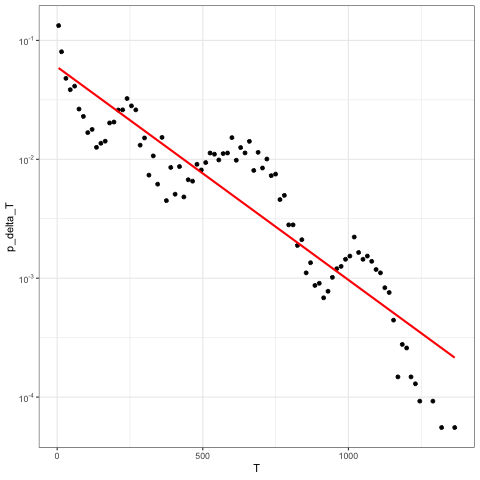

In [40]:
%%R

require(scales) # pour accéder aux fonctions de formatage des graduations

# Données temporelles des activités discrétisées par pas de 15 min
time_act <- read.csv("Data/time_act.csv", sep = ";") 

T <- time_act$Var1

p_delta_T <- time_act$Freq/sum(time_act$Freq)

act_time_graph <- ggplot(time_act, aes(x=T, y=p_delta_T)) + 
                  geom_point() +
                  scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                                labels = trans_format("log10", math_format(10^.x))) +
                  geom_smooth(col = 'red',method = "lm", se = F) +
                  theme_bw()
                               
act_time_graph

La figure ci-dessus illustre la distribution $P(\Delta t)$ pour les données de l'EMD sur lec activités fixes (`id < 100`). La figure est affichée selon une échelle _Linéaire-Log_. Les creux et bosses traduisent une prévalence de certains horaires types. 

La ligne rouge illustre un ajustement poissonien. Le fait que les données suivent la droite montre qu'ici $P(\Delta t)$ décroit de façon exponentielle. 

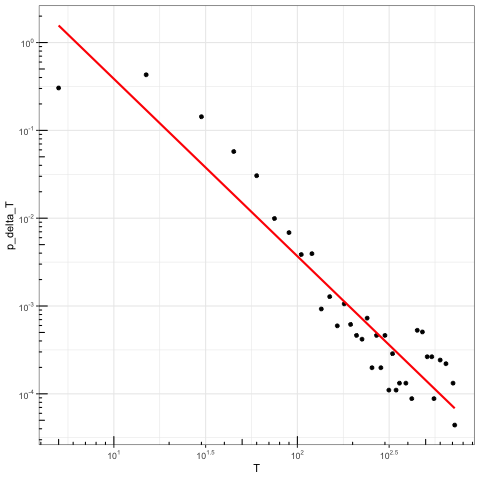

In [41]:
%%R
                   
time_tsp <- read.csv("Data/time_tsp.csv", sep = ";")

# Données temporelles des modes de déplacement discrétisées par pas de 15 min
T <- time_tsp$Var1

p_delta_T <- time_tsp$Freq/sum(time_tsp$Freq)

move_time_graph <- ggplot(time_tsp, aes(x=T, y=p_delta_T))  + geom_point() +
                     scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
                                   labels = trans_format("log10", math_format(10^.x))) +
                     scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                                   labels = trans_format("log10", math_format(10^.x))) +
                     geom_smooth(col = 'red', method = "lm", se=F) +
                     annotation_logticks() +
                     theme_bw()
                                   
                                   
move_time_graph 

La figure ci-dessus illustre la distribution $P(\Delta t)$ pour les données de l'EMD sur lec activités fixes (`id >= 100`). La figure est affichée selon une échelle _Log-Log_. 

La ligne rouge illustre un ajustement selon une loi à queue lourde. Le fait que les données suivent la droite montre qu'ici $P(\Delta t)$ décroit selon un modèle $\approx(\Delta t)^{-\alpha}$ avec ($\alpha \geq 1$).


## 1.5 Diagramme de flots <a class="anchor" id="1-5"></a>

De la même façon que l'on peut représenter un flot de population d'une région à une autre Abel et al., [Quantifying Global International Migration Flows](https://science.sciencemag.org/content/343/6178/1520), Sciences (2014), on peut représenter le flot d'une activité $a_i$ à une activité $a_j$.

Cette représentation adopte alors la forme d'une matrice de Origine-Destination $T$. 
$$
T = \begin{pmatrix} 
0 & t_{12} & \cdots & t_{1n} \\
t_{21} & 0 & \cdots & t_{2n} \\
\vdots & \vdots& \ddots & \vdots \\
t_{n1} & t_{n2} & \cdots & 0 \\
\end{pmatrix}
$$

où $t_{ij}$ représente le nombre de déplacements de l'activité $a_i$ à l'activité $a_j$. 

In [15]:
##########################################
## CONSTRUCTION DE LA MATRICES DE FLOTS ##
##########################################

def build_flows(sequences) :
    D = dict()
    for seq in sequences :
        s = [s for s in seq if s < 100] # Sequence sans move
        s = [s[0] for s in groupby(s)] # Suppresion des duplicats consécutifs
        for i in range(len(s)-1) :
            if(s[i] < 100) :
                if(s[i] not in D.keys()) :
                    D[s[i]] = dict()
                if(s[i+1] not in D[s[i]].keys()) :
                    D[s[i]][s[i + 1]] = 1
                else :
                    D[s[i]][s[i+1]] += 1
    
    flow = pd.DataFrame(columns=['i', 'j', 'tij'])
    
    for k in sorted (D.keys()) :
        for k2 in sorted (D[k].keys()) :
            flow = flow.append(pd.Series(["a"+str(k), "a"+str(k2), D[k][k2]], index=flow.columns ), ignore_index=True)
    
    return flow

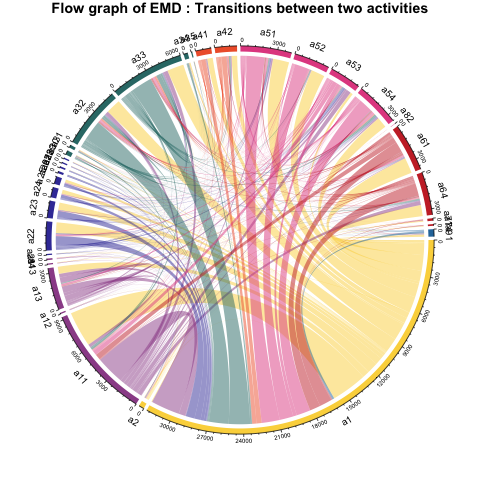

In [43]:
%%R

flow <- read.csv("Data/flow.csv", sep = ";")
grid.col = c(a1 = "#FBD54A",
             a2 = "#FBD54A",
             a11 = "#9B5097",
             a12 = "#9B5097",
             a13 = "#9B5097",
             a81 = "#9B5097",
             a43 = "#9B5097",
             a30 = "#307876",
             a31 = "#307876",
             a32 = "#307876",
             a33 = "#307876",
             a34 = "#307876",
             a35 = "#307876",
             a21 = "#3E3DA6",
             a22 = "#3E3DA6",
             a23 = "#3E3DA6",
             a24 = "#3E3DA6",
             a25 = "#3E3DA6",
             a26 = "#3E3DA6",
             a27 = "#3E3DA6",
             a28 = "#3E3DA6",
             a29 = "#3E3DA6",
             a41 = "#EF6136",
             a42 = "#EF6136",
             a51 = "#E35090",
             a52 = "#E35090",
             a53 = "#E35090",
             a54 = "#E35090",
             a82 = "#E35090",
             a61 = "#C92F31",
             a62 = "#C92F31",
             a63 = "#C92F31",
             a64 = "#C92F31",
             a71 = "#C92F31",
             a72 = "#C92F31",
             a73 = "#C92F31",
             a74 = "#C92F31",
             a91 = "#2A77AA")

chordDiagram(flow, grid.col = grid.col)

title("Flow graph of EMD : Transitions between two activities")

## 1.6 Entropies <a class="anchor" id="1-6"></a>

L'entropie peut nous permettre de déterminer le caractère predictible d'une trajectoire sémantique i.e séquence d'activités Song et al., [Limits of Predictability in Human Mobility](https://science.sciencemag.org/content/327/5968/1018), Sciences (2010).

Les auteurs proposent trois types d'entropies : 
- Entropie randomisée: $H^{rand} = \log_2(\delta(S))$
- Entropie non-corrélée: $H^{unc} = -\sum_{i \in \delta(S)} p_i \log_2(p_i)$
- Entropie réelle: $H = -\sum_{S' \subset S} p_{S'} \log_2(p_{S'})$

Cette dernière se base sur la notion de [complexité de Lempel-Ziv](https://en.wikipedia.org/wiki/Lempel-Ziv_complexity) au sein des séquences finies de symboles. 

Le calcul de $H$ repose sur le calcul préalable des probabilités d'apparition pour chaque sous-séquence $S'$ de $S$. Cependant, lorsque les séquences sont de grande taille, $H$ devient incalculable exactement. 

Pour pallier à cet effet, on peut utiliser un estimateur $H^{est} \approx H$ tel que $\lim_{|S| \rightarrow \infty} H^{est} = H$ Kontoyiannis et al., [Nonparametric Entropy Estimation for Stationary Processes and Random Fields](https://ieeexplore.ieee.org/document/669425), IEEE Trans. on Info. Theory (1998).

$$H^{est} = \left(\frac{1}{|S|} \sum_i \lambda_i \right)^{-1} \log_2(|S|)$$

Où $\lambda_i = \text{argmin}_{i \leq k \leq n} \{s_i...s_k \notin s_1...s_{i-1}\}$ est la taille de la plus petite sous-séquence débutant à $i$ et non contenue dans le préfixe 1 à $i-1$.

In [44]:
from math import *

def lz_entropy(w) :
    sum_lambda = 0.0
    for i in range(0, len(w)) :
        lambda_i = 0
        for k in range(1, len(w)-i+1) :
            if(w[i: i + k] not in w[0: i]) :
                lambda_i = k
                break
        sum_lambda += lambda_i
    return 1.0 / ((sum_lambda) / len(w) ) * (log(len(w))  / log(2))

def rand_entropy(w) :
    return log(len(set(w))) / log(2) 

def unc_entropy(w) :
    entropy = 0.0
    for s in set(w) : 
        entropy += (w.count(s) / len(w)) * log(w.count(s) / len(w)) / log(2)
    return -entropy

In [45]:
##########################
## CALCUL DES ENTROPIES ##
##########################

df_entro = pd.DataFrame()
col_entro = [[], [], [], []]

buff_name = emd['id_seq'][0]
seq_i = ""
symbol = 'a'
D = dict()
for index, row in emd.iterrows():
    s = row['activity']
    if (row['id_seq'] != buff_name):       
        D = dict()
        entro_col = append_col(col_entro, [buff_name, rand_entropy(seq_i),
                                           unc_entropy(seq_i), lz_entropy(seq_i)])
        buff_name =  row['id_seq']
        seq_i = ""
        symbol = 'a'
    if(s not in D):
        D[s] = symbol
        symbol = chr(ord(symbol) + 1)
        
    # Ajout proportionnel de symboles à la durée
    for i in range(0, int(int(row['time']) / 5) - 1):
        seq_i += str(D[s])
    seq_i += str(D[s])
    
col_entro = append_col(col_entro, [buff_name, rand_entropy(seq_i),
                                  unc_entropy(seq_i), lz_entropy(seq_i)])
df_entro["id_seq"] = col_entro[0]
df_entro["H_rand"] = col_entro[1]
df_entro["H_unc"] = col_entro[2]
df_entro["H"] = col_entro[3]

print(df_entro)

#df_entro.to_csv(r"entropy.csv", index=False)

       id_seq    H_rand     H_unc         H
0          X1  1.584963  1.123856  0.331673
1          X2  2.000000  0.773962  0.510568
2          X3  2.000000  1.323505  0.450318
3          X4  1.584963  0.604696  0.289713
4          X5  1.584963  0.566091  0.359651
...       ...       ...       ...       ...
10000  X10001  1.584963  1.172015  0.360597
10001  X10002  1.584963  1.118228  0.334097
10002  X10003  1.584963  0.813815  0.335050
10003  X10004  2.000000  1.335862  0.386996
10004  X10005  2.807355  1.685403  0.492806

[10005 rows x 4 columns]


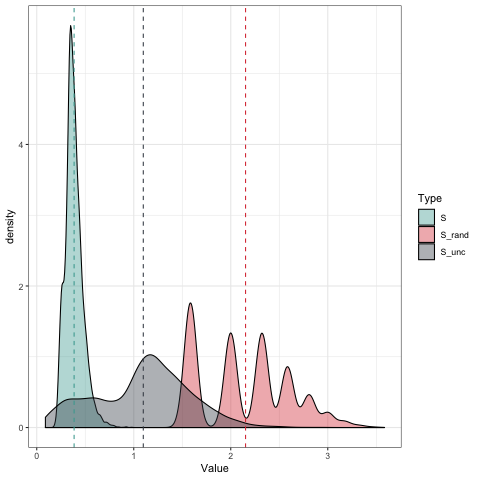

In [46]:
%%R

# Chargement des entropies
entropies <- read.csv("Data/entropy2.csv", sep = ";")

mu <- ddply(entropies, "Type", summarise, grp.mean=mean(Value))
head(mu)

#pdf("entropie.pdf", width = 9, height = 7 )

p <- ggplot(entropies, aes(x=Value, fill=Type)) +
     geom_density(alpha=0.4) +
     scale_fill_manual(values=c("#47A79F", "#DB3C42", "#424A54")) +
     geom_vline(data=mu, aes(xintercept=grp.mean, color=Type),
     linetype="dashed", color =c("#47A79F", "#DB3C42", "#424A54"))+ 
     theme_bw()

p

La figure ci-dessus montre les distributions des entropies $P(H), P(H^{unc})$ et $P(H^{rand})$ pour l'ensembles des séquences de l'EMD. 

Le résultat le plus impressionnant est le pic que l'on peut observer dans la distribution de $P(H)$ comparée à   $P(H^{rand})$ et $P(H^{unc})$. En effet, $P(H^{rand})$ indique une moyenne aux alentours de $\approx 2. 2$, ce qui montre que chaque nouvelle activité dans une séquence représente 2.2 bits de nouvelle information. 

Ainsi, pour un utilisateur qui choisit au hasard sa prochaine activité, on pourrait espérer déterminer celle-ci, en moyenne, en $2^{H^{rand}} \approx 4.6$ soit environ 5 coups.

En revanche, le fait que $P(H)$ culmine autour de 0.4 indique qu'en réalité l'incertitude liée aux activités d'un utilisateur n'est pas 5 mais $2^{0.4} \approx 1.32$, c'est-à-dire moins de 2. 

# 2 - Clustering hiérarchique <a class="anchor" id="2"></a>

In [48]:
%%R

## CHARGEMENT DE LA MATRICE DE DISTANCE ##
ced_emd <- read_delim("Data/emd_10005.csv", 
    " ", escape_double = FALSE, col_names = FALSE, 
    trim_ws = TRUE)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double()
)

R[write to console]: See spec(...) for full column specifications.



In [17]:
CED_matrix  = np.loadtxt(open("Data/emd_10005.csv", "rb"), delimiter=" ")

## 2.1 Création du dendrogramme <a class="anchor" id="2-1"></a>

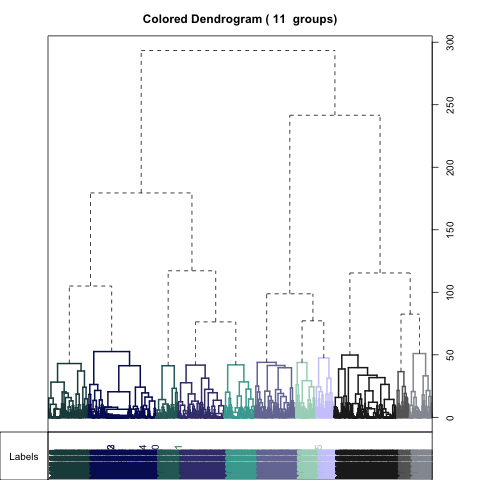

In [51]:
%%R

source("http://addictedtor.free.fr/packages/A2R/lastVersion/R/code.R")

ced <- as.dist(ced_emd)
cedhc <- hclust(ced, method="ward.D2")

nb_clust <- best_cut(cedhc, 5, 15)

groups <- cutree(cedhc, k = nb_clust)

#pdf("dendrogramme.pdf", width = 9, height = 7 )

A2Rplot(cedhc, k = nb_clust, boxes = TRUE, col.down = clusters_col)


In [50]:
%%R

groups <- norm_aff_clust(cedhc, groups)

clust_emd <- merge(x=df_groups, y=emd, by="id_seq", all=FALSE)

#write.table(clust_emd, "clust_emd.csv", sep = ";", row.names = F)

Un indicateur classique pour estimer la qualité d'un clustering est l'indice de silhouette présenté dans Rousseeuw, [Silhouettes: A graphical aid to the interpretation and validation of cluster analysis](https://www.researchgate.net/publication/222451107_Rousseeuw_PJ_Silhouettes_A_Graphical_Aid_to_the_Interpretation_and_Validation_of_Cluster_Analysis_Comput_Appl_Math_20_53-65), Journal of Computational and Applied Mathematics, (1987). 

Cet indicateur mesure la cohésion du cluster (distance moyenne des points du même cluster) et la séparation (distance moyenne au cluster le plus proche). Le score $Sil$ de Silhouette est normalisé entre $[-1,1]$:
- Si $Sil \rightarrow 1$, alors le point est correctement classé
- Si $Sil \rightarrow -1$, alors le point est mal classé. 

Néanmoins, il reste difficile d'interpréter le score de Silhouette pour CED dû à la topologie peu intuitive de l'espace ainsi que la forme des clusters. En outre, Silhouette est un score généralement utilisé pour des clusters hypersphériques, ce qui n'est pas garanti ici malgré l'utilisation du critère de Ward lors de la classification ascendante hiérarchique. 

Un exemple de ce phénomène peut-être trouvé dans Moreau et al., [Learning Analysis Patterns using a Contextual Edit Distance](http://ceur-ws.org/Vol-2572/paper17.pdf), DOLAP (EDBT) (2019) où sur un jeu de données labélisé, CED exhibé un clustering parfait et qui pourtant n'affiché un score de Silhouette [que] de 0.49.

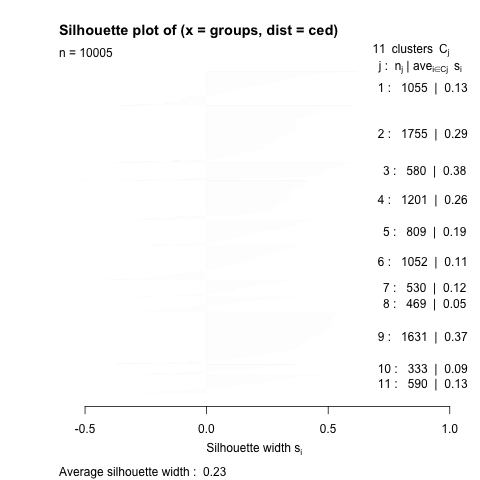

In [51]:
%%R

sil_cl <- silhouette(groups, ced)

plot(sil_cl, col = clusters_col)


In [52]:
%%R

clust_emd <- read.csv("Data/clust_emd.csv", sep = ";", encoding = "UTF-8")

In [54]:
emd_clust = pd.read_csv("Data/clust_emd.csv", sep=";")

# Listes des ID des séquences sémantiques par clusters
seq_emd_clust = dict()
buff_name = emd_clust['id'][0]
id_clust = emd_clust['id_clust'][0]

for index, row in emd_clust.iterrows():
    if (row['id'] != buff_name):
        if(id_clust not in seq_emd_clust.keys()) :
            seq_emd_clust[id_clust] = []
        seq_emd_clust[id_clust].append(buff_name)
        buff_name = row['id']
        id_clust = row['id_clust']
        
if(id_clust not in seq_emd_clust.keys()) :
    seq_emd_clust[id_clust] = []
seq_emd_clust[id_clust].append(buff_name)       

## 2.2 Régularité des clusters <a class="anchor" id="2-4"></a>

Comme nous l'avons fait précédemment, on peut analyser la régularité des séquences au sein de chaque cluster ce qui nous renseignne à la fois sur la taille des séquences sémantiques et sur le nombre d'activités différentes pratiquées.

In [55]:
####################################
# RÉGULARITÉ SÉQUENCES PAR CLUSTER #
####################################

df_reg_clust = pd.DataFrame()
reg_clust_col = [[], [], [], [], []]

for k in sorted(seq_emd_clust.keys()) : 
    for i in seq_emd_clust[k] :
        cols = ["X"+str(i), k, len(seq_emd[i-1]), delta(seq_emd[i-1]), len(seq_emd[i-1])/delta(seq_emd[i-1])]
        reg_clust_col = append_col(reg_clust_col, cols)
        
df_reg_clust["id_seq"] = reg_clust_col[0]
df_reg_clust["id_clust"] = reg_clust_col[1]
df_reg_clust["len"] = reg_clust_col[2]
df_reg_clust["delta"] = reg_clust_col[3]
df_reg_clust["reg"] = reg_clust_col[4]

print(df_reg_clust)

#df_reg_clust.to_csv(r"reg_clust.csv", index=False)

      id_seq  id_clust  len  delta       reg
0        X27         1   13      6  2.166667
1        X31         1    9      5  1.800000
2        X39         1   13      5  2.600000
3        X81         1    7      4  1.750000
4        X91         1   17      6  2.833333
...      ...       ...  ...    ...       ...
10000  X9859        11    5      4  1.250000
10001  X9919        11    9      5  1.800000
10002  X9966        11   13      7  1.857143
10003  X9980        11    9      6  1.500000
10004  X9983        11    9      5  1.800000

[10005 rows x 5 columns]


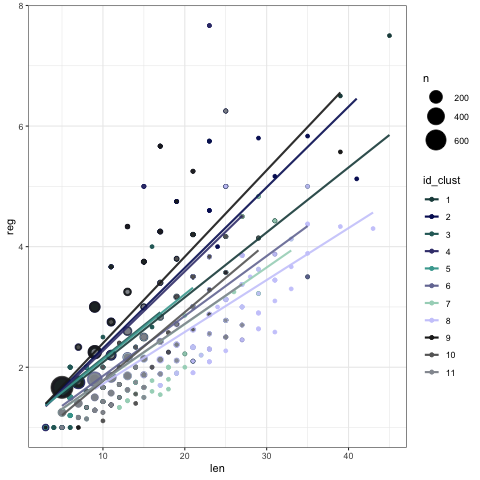

In [57]:
%%R

clust_stats_emd <- read.csv("Data/reg_clust.csv", sep = ",")

clust_stats_emd$id_clust <- as.factor(clust_stats_emd$id_clust)

p <- ggplot(clust_stats_emd, aes(x = len, y = reg, color = id_clust)) +
            geom_point(aes(color = id_clust)) +
            geom_count() +
            geom_smooth(method="lm", se = F) + # fullrange=TRUE 
            scale_color_manual(values = alpha(clusters_col, 0.9))+
            scale_size(range = c(1, 10)) +
            theme_bw()
p


## 2.3 Entropie des clusters <a class="anchor" id="2-2"></a>

On peut étudier l'entropie des clusters afin de voir si certains groupes d'individus on une mobilité plus riche que d'autres. 

In [58]:
%%R

entropies <- read.csv("Data/entropy.csv", sep = ",")
clust_stats_emd <- merge(x=clust_stats_emd, y=entropies, by="id_seq", all=F)

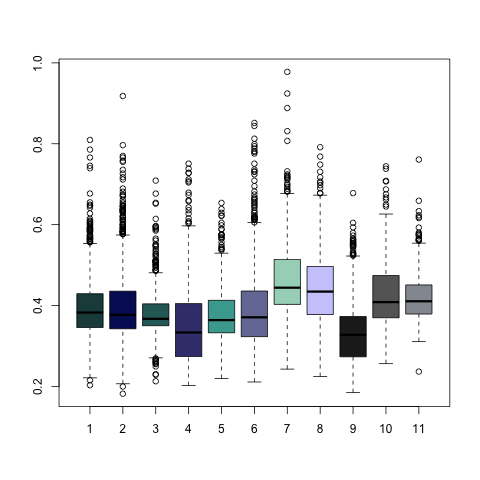

In [59]:
%%R 

#pdf("entropies_boxplot.pdf", width = 11, height = 8)
clust_stats_emd$id_clust <- as.factor(clust_stats_emd$id_clust)

boxplot((clust_stats_emd$H)~(clust_stats_emd$id_clust), data=clust_stats_emd, col = clusters_col)

## 2.4 Fréquences des activités dans les clusters <a class="anchor" id="2-3"></a>

### 2.4.1 Graphique à barres <a class="anchor" id="2-3-1"></a>

Les graphiques à barres permettent de donner une vision simple et normalisée de l'ensemble des activités pratiquées dans un cluster.


Afin d'éviter un trop grand nombre de catégorie au sein du diagramme, on remonte dans la hiérarchie de l'ontologie chaque activité. 

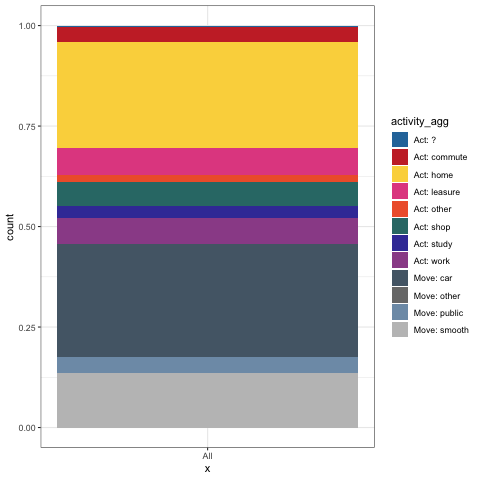

In [60]:
%%R

freq_act <- as.data.frame(table(clust_emd$activity_agg))

#pdf("barplot_all.pdf", width = 4, height = 10)

p <- ggplot(clust_emd) +
geom_bar(mapping = aes(x = "All", fill = activity_agg), position="fill")+
scale_fill_manual(values= unlist(lapply(freq_act[,1], col_emd))) +
theme_bw()

p

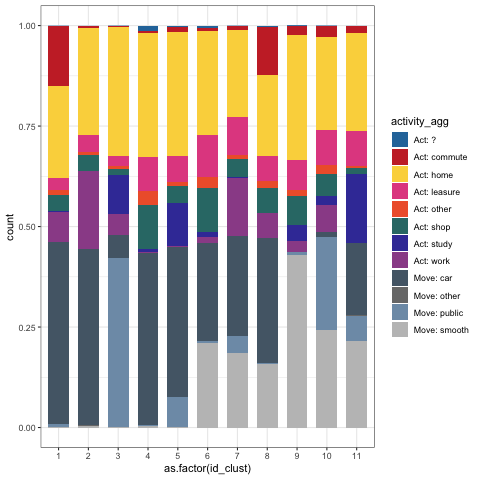

In [61]:
%%R

freq_act <- as.data.frame(table(clust_emd$activity_agg))
#pdf("barplot.pdf", width = 9, height = 10 )
p <- ggplot(clust_emd) +
geom_bar(width=0.7, mapping = aes(x = as.factor(id_clust), fill = activity_agg), position = "fill")+
scale_fill_manual(values= unlist(lapply(freq_act[,1], col_emd))) +
theme_bw()

p

### 2.4.2 Diagramme Mosaïque <a class="anchor" id="2-3-2"></a>

La représentation des activités au sein d'un [diagramme mosaïque](http://alumni.media.mit.edu/~tpminka/courses/36-350.2001/lectures/day12/) permet de modéliser les fréquences d'apparition de chaque entité au sein de chaque cluster, tout comme les graphiques à barres. 

En outre, une interprétation probabiliste peut-être déduite de ce graphique, on a les relation de proportionnalité suivante : 
- surface $\propto P(\mathscr{C}_i \cap a_j)$  
- largeur $\propto P(a_j)$  
- hauteur $\propto P(\mathscr{C}_i | a_j)$  


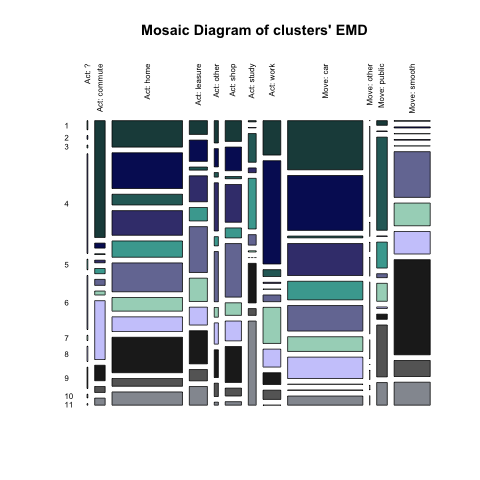

In [62]:
%%R


#pdf("mosaic.pdf", width = 10, height = 10)

mosaicplot(table(clust_emd$activity_agg, clust_emd$id_clust),
           col = clusters_col,
           las =2,
           shade = F,
           main = "Mosaic Diagram of clusters' EMD")


### 2.4.3 Résidus de Pearson et inférences statistiques <a class="anchor" id="2-3-3"></a>

Afin de faire des inférences sur nos clusters et nos populations étudiées, il est nécessaire de disposer d'une mesures significativité statistique. 

Inspiré du test du $\chi^2$, les résidus de Pearson  Haberman, [The Analysis of Residuals in Cross-Classified Tables](https://www.jstor.org/stable/2529686?casa_token=C3ccuUlgplsAAAAA:NJMOIdyA0ArQzdmLX-gbty_dMnrYX8bApGaL80qUK0pF4MsQGcH_Mx2bhMnIhjFu3_hppTmXkubu8QcFFpVNHBsbzdiGl1XwQ-_a4TLShPY3Kc58dCA&seq=1#metadata_info_tab_contents), Biometrics, (1973) sont définis tels que : 
$$r_{ij} = \frac{n_{ij} - t_{ij}} {\sqrt{t_{ij}}}$$

Où $n_{ij}$ est l'effectif observé dans la table de contingence ligne $i$, colonne $j$. Le coefficient $t_{ij}$ quant à lui est l'effectif théorique. Sous hypothèse d'indépendance, on a $t_{ij} = \frac{n_{i+} + n_{+j}}{N}$. 

La statistique $\chi^2$ est alors : $\chi^2 = \sum_i \sum_j r_{ij}^2$

Le résidu $r_{ij}$ mesure alors l’attraction (résidus positifs) ou la répulsion (résidus négatifs) des modalités $a_i$ et $\mathscr{C}_j$. Les unités étant en écart-type, un résidu supérieur à 2 ou inférieur à -2 représente un écart significatif à 95%. 


Friendly étend la visualisation des diagrammes mosaïques afin d'y faire figurer les résidus de Pearson Friendly., [Extending Mosaic Displays: Marginal, Partial, and Conditional Views of Categorical Data](https://www.researchgate.net/publication/2508823_Extending_Mosaic_Displays_Marginal_Partial_and_Conditional_Views_of_Categorical_Data), Journal of Computational and Graphical Statistics. (1999). 

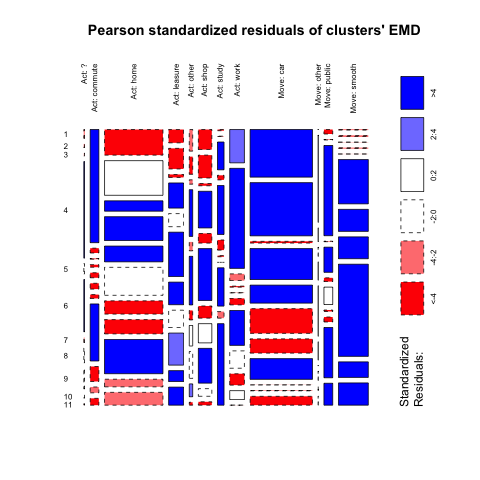

In [63]:
%%R
#pdf("mosaic_pearson.pdf", width = 11.8, height = 10)
mosaicplot(table(clust_emd$activity_agg, clust_emd$id_clust),
           col = cluster_col,
           las =2,
           shade = TRUE,
           main = "Pearson standardized residuals of clusters' EMD")


Les résidus peuvent être interprétés de façon intuitive (et peu formelle...) de la façon suivante : 

- Si une cellule est blue, alors on peut dire que les modalité $(a_i, b_j)$ sont liées favorablement, c'est-à-dire que l'on observe une forte proportion de la variable $b_j$ conjointe avec $a_i$, par rapport aux autres variables de la ligne $b_{j'\neq j}$. 
Par exemple, on peut dire ici que les individus du `cluster 1` sont souvent pourvus de l'activité `Trans. public` par rapport aux autres activités. 

- Si une cellule est blue, alors on peut dire que les modalité $(a_i, b_j)$ sont liées défavorablement, c'est-à-dire que l'on observe une faible proportion de la variable $b_j$ conjointe avec $a_i$, par rapport aux autres variables de la ligne $b_{j'}$
Par exemple, on peut dire ici que les individus du `cluster 2` sont souvent peu pourvus de l'activité `Work` par rapport aux autres activités. 

Comme nous l'avons vu plus haut, ces résultats sont à prendre selon un niveau de confiance relative à 95% (voire 99%). 

## 2.5 Flots des clusters <a class="anchor" id="2-5"></a>

Les graphiques de flots de chaque clusters permettent à la fois de nous renseigner sur les proportions d'activités pratiquées mais aussi, sur leurs relations de précédence directe. 

In [37]:
# Génération des matrices de flots pour chaque clusters

for k in seq_emd_clust.keys() :  
    flow = build_flows([seq_emd[i-1] for i in seq_emd_clust[k]])

    name_flow = r"flow"+str(k)+".csv"
    flow.to_csv(name_flow, index=False)

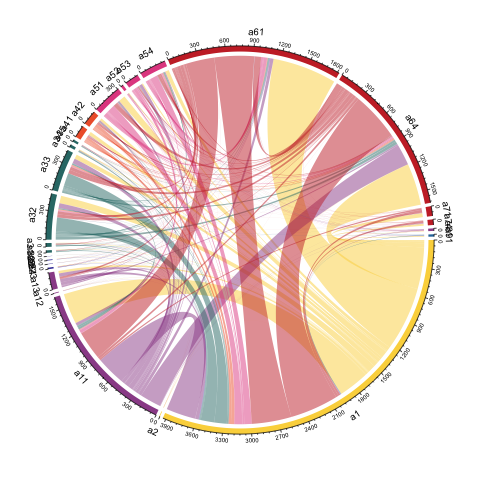

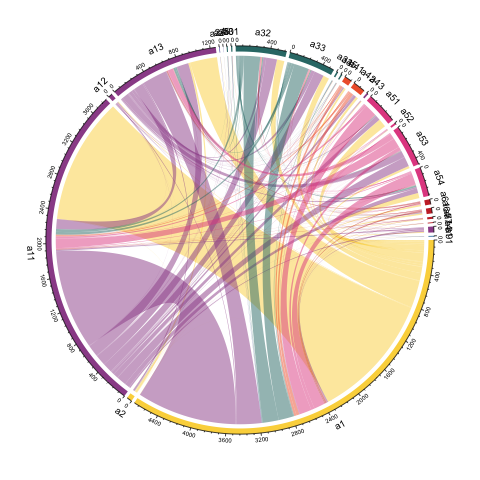

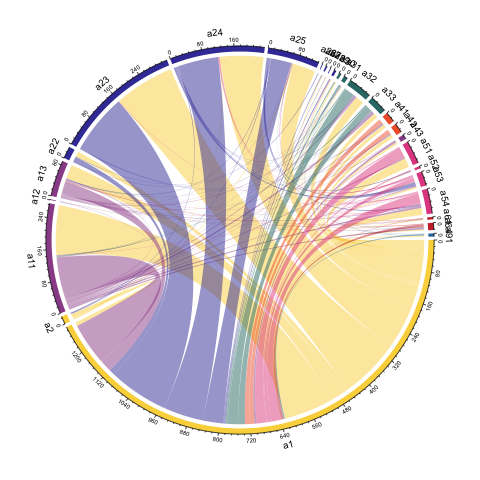

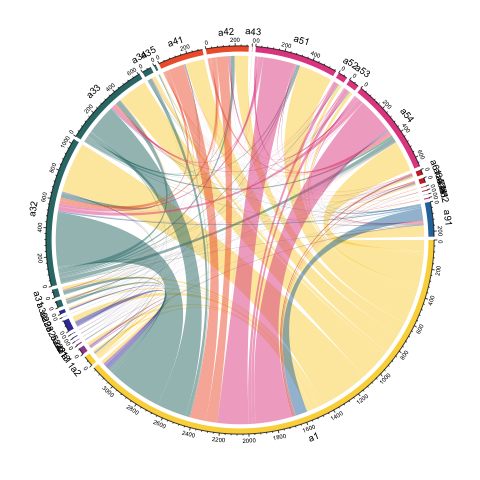

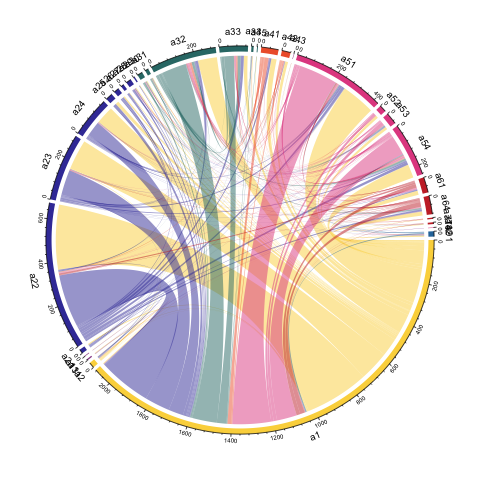

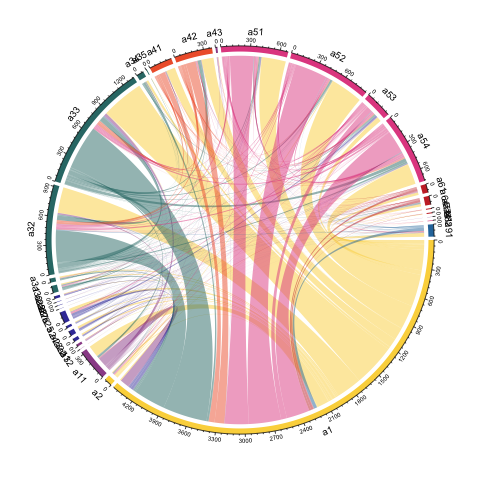

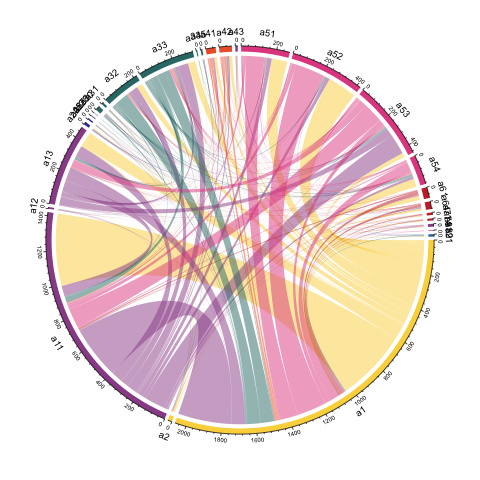

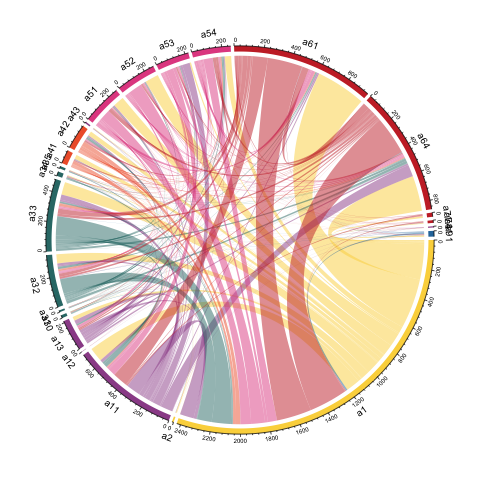

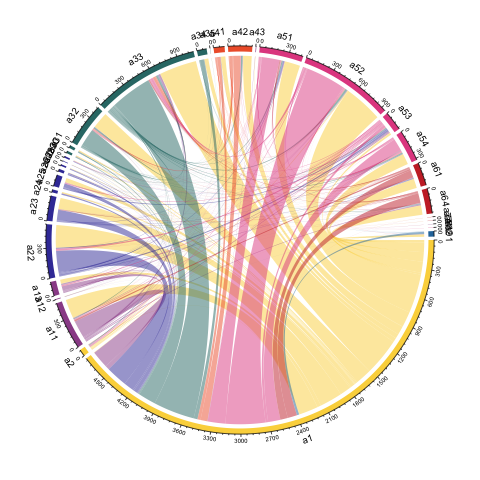

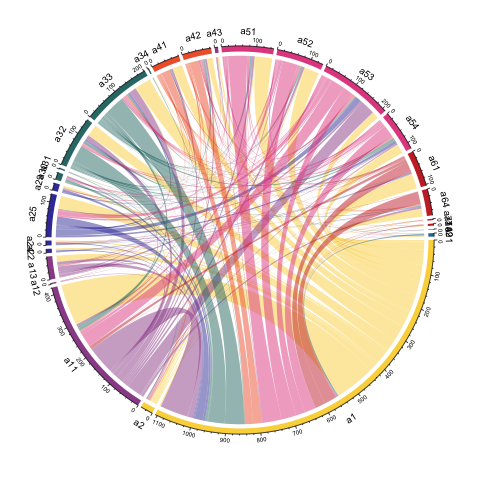

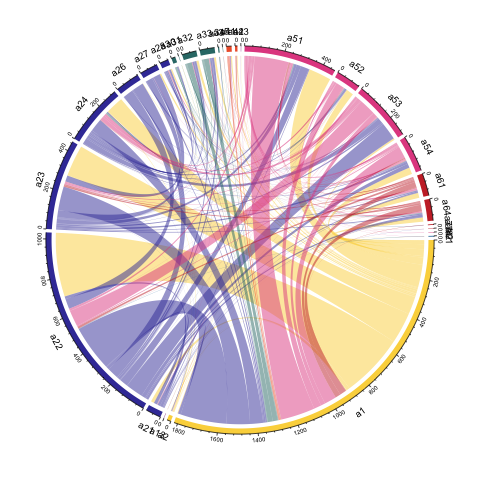

In [38]:
%%R 

for(i in seq(11)) {
    file <- paste(paste("Flows/flow", toString(i), sep=""), ".csv", sep="")
    flow <- read.csv(file, sep = ",")
    chordDiagram(flow, grid.col = grid.col)
}


## 2.6 Extraction des medoids, mode et diametre des clusters <a class="anchor" id="2-6"></a>

Le _medoid_ est l'élément $m$ qui minimise la distance $d$ à tous les autres membres du groupe : 
$$m = \text{argmin}_{x\in C}\left\{ \sum_{y \in C} d(x,y) \right\}$$

en ce sens, il peut-être utilisé pour avoir une indication sur le comportement type d'un groupe d'individus. 


Le mode _M_ lui est l'élément qui est le plus présent dans le groupe. Il peut-être déduit à partir de la matrice de distance sous l'hypothèse que $d$ est séparable tel que : 
$$ M = \text{argmax}_{x\in C}\left\{ \left| \bigcup_{y \in C | d(x,y) = 0} \{y\} \right| \right\}$$


Enfin, le diamètre du cluster $C$ est défini comme la distance maximale entre deux éléments $x,y in C$ : 
$$diam = \max_{x,y \in C}\{d(x,y)\}$$

In [64]:
def sub_dist_matrix(clusters, D_matrix):
    sub_D_matrix = dict()
    for k in clusters.keys() :
        C_k = clusters[k]
        subMatrix = np.zeros((len(C_k), len(C_k)))
        for i in range(len(C_k)):
            for j in range(i, len(C_k)):
                subMatrix[i, j] = D_matrix[C_k[i] - 1, C_k[j] - 1]
                subMatrix[j, i] = subMatrix[i, j]
        sub_D_matrix[k] = subMatrix
    return sub_D_matrix

In [65]:
def to_emoji(a) :
    if a in [1, 2, "home"] :
        return("🏡")
    
    if a in [11, 12, 13, 81, 43, "work"] :
        return("💼")
    
    if a in [30, 31, 32, 33, 34, 35, "shop"] :
        return("🛒")
    
    if a in [21, 22, 23, 24, 25, 26, 27, 28, 29, "study"] :
        return("🏫")
    
    if a in [41, 42, "care"] :
        return("📝")
    
    if a in [51, 52, 53, 54, 82, "leasure"] :
        return("🤪")
    
    if a in [61, 62, 63, 64, 71, 72, 73, 74, "commute"] :
        return("🔁")
    
    if a in [91, "?"] :
        return("❓")
    
    
    ## Modes de transport ##
    if a in [113, 114, 115, 116, 121, 122, 161, 171, 181, 182, "Trans. car"] :
        return("🚗")
    
    if a in [100, 110, 111, 112, 193, 194, 195, "Trans. smooth"] :
        return("👟")
    
    if a in [191, 192, 196, "Trans. other"] :
        return("✈️")
    
    if a in [151, 131, 133, 138, 139, 141, 142, "Trans. public"] :
        return("🚃")
    
    else :
        return("")

    
def seq_to_emojis(S) :
    buff = ""
    for s in S :
        buff += to_emoji(int(s)) + " "
    return buff 

In [66]:
def diameter(sub_matrix, cluster):
    return np.max(sub_matrix)

def diameter_couple(sub_matrix, cluster):
    pos = np.argmax(sub_matrix)
    (i, j) = (int(pos / sub_matrix.shape[1]),  pos % sub_matrix.shape[1])
    return (cluster[i], cluster[j])   
    
def mode(sub_matrix, cluster):
    mode = np.argmax(np.shape(sub_matrix)[0] - np.count_nonzero(sub_matrix, axis=0))
    return cluster[mode]

def medoid(sub_matrix, cluster):
    m = np.argmin(sub_matrix.sum(axis=0))
    return cluster[m]
    
sub_D_matrix = sub_dist_matrix(seq_emd_clust, CED_matrix)
for k in sorted(seq_emd_clust.keys()) :
    sub_matrix = sub_D_matrix[k]
    cluster = seq_emd_clust[k]
        
    print("--- Cluster", k,"---\n")
    print("Mode:\t", seq_to_emojis(seq_emd[mode(sub_matrix, cluster)-1]))
    print("Medoid:\t", seq_to_emojis(seq_emd[medoid(sub_matrix, cluster)-1]))
    print("Diam: ", diameter(sub_matrix, cluster))
    couple_diam = diameter_couple(sub_matrix, cluster)
    print("\tX(",couple_diam[0], ") =", seq_to_emojis(seq_emd[couple_diam[0]-1]),
          "\n\t vs \n\tY(",couple_diam[1], ") =", seq_to_emojis(seq_emd[couple_diam[1]-1]))
    print("\n")
    

--- Cluster 1 ---

Mode:	 🏡 🚗 🔁 🚗 💼 🚗 🏡 
Medoid:	 🏡 🚗 🔁 🚗 💼 🚗 🔁 🚗 🏡 
Diam:  15.2698
	X( 1415 ) = 🏡 🚗 🔁 🚗 🏡  
	 vs 
	Y( 8732 ) = 🏡 🚗 🤪 🚗 🔁 🚗 🏡 🚗 📝 🚗 🛒 🚗 🛒 🚗 📝 🚗 📝 🚗 🏡 🚗 🔁 🚗 🤪 🚗 🔁 🚗 🤪 🚗 🤪 🚗 🏡 🚗 🤪 🚗 🏡 


--- Cluster 2 ---

Mode:	 🏡 🚗 💼 🚗 🏡 
Medoid:	 🏡 🚗 💼 🚗 💼 🚗 🏡 
Diam:  28.2143
	X( 3057 ) = 🏡 🚗 🛒 🚗 🏡  
	 vs 
	Y( 9761 ) = 🏡 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 🏡 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 💼 🚗 🏡 🚗 🤪 👟 🤪 


--- Cluster 3 ---

Mode:	 🏡 🚃 🏫 🚃 🏡 
Medoid:	 🏡 🚃 🏫 🚃 🏡 
Diam:  9.0
	X( 2089 ) = 🏡 🚃 🏫 🚃 🏡  
	 vs 
	Y( 2479 ) = 🏡 🚗 📝 🚃 📝 🚃 📝 🚗 🏡 🚗 🛒 🚗 🏡 


--- Cluster 4 ---

Mode:	 🏡 🚗 🛒 🚗 🏡 
Medoid:	 🏡 🚗 🛒 🚗 🏡 
Diam:  16.75
	X( 3929 ) = 🤪 🚗 🏫 🚗 🤪  
	 vs 
	Y( 4847 ) = 🏡 🚗 ❓ 🚗 ❓ 🚗 💼 🚗 💼 🚗 🏡 🚗 🔁 🚗 🏡 🚗 ❓ 🚗 🏡 🚗 🔁 🚗 🏡 🚗 🤪 🚗 🏡 


--- Cluster 5 ---

Mode:	 🏡 🚗 🏫 🚗 🏡 
Medoid:	 🏡 🚗 🏫 🚗 🏡 
Diam:  12.6751
	X( 4945 ) = 🏡 🚃 🚗 🏫 🚃 🚗 🏡  
	 vs 
	Y( 6018 ) = 🏡 🚗 🏫 🚗 🤪 🚗 🔁 🔁 🚗 🚗 🤪 🔁 🚗 🚗 🔁 🚗 🏡 🚗 🤪 🚗 🏡 


--- Cluster 6 ---

Mode:	 🏡 🚗 💼 🚗 🏡 👟 🛒 👟 🏡 
Medoid:	 🏡 🚗 🛒 🚗 🏡 👟 🤪 👟 🏡 
Diam:  23.98
	X( 2031 ) = 🏡 🚃 🏡 👟 🤪 👟 🏡  
	 

## 2.7 Histogramme des distances dans les clusters <a class="anchor" id="2-7"></a>

Afin d'appréhenser au mieux l'espace formé par CED et les séquences sémantiques, on peut s'intéresser à la distance entre éléments dans chacun des clusters. 

In [80]:
df_dist = pd.DataFrame()
col_dist = [[], []]
size = np.shape(sub_D_matrix[k])[0]

for k in sub_D_matrix.keys() :
    cols_sum = np.sum(sub_D_matrix[k], axis=0)
    normalize = lambda x, a: x/a 
    dist_sub = [normalize(x, size-1) for x in cols_sum]
    for d in cols_sum:
        col_dist = append_col(col_dist, [d, k])
    
df_dist["dist"] = col_dist[0]
df_dist["clust"] = col_dist[1]

print(df_dist)
df_dist.to_csv(r"dist_clust.csv", index=False)

              dist  clust
0      1107.644030      3
1      2467.658497      3
2      1505.760065      3
3      1098.597735      3
4       961.217393      3
...            ...    ...
10000  1739.606294      5
10001  2604.644110      5
10002  2818.768955      5
10003  1864.307479      5
10004  1947.529375      5

[10005 rows x 2 columns]


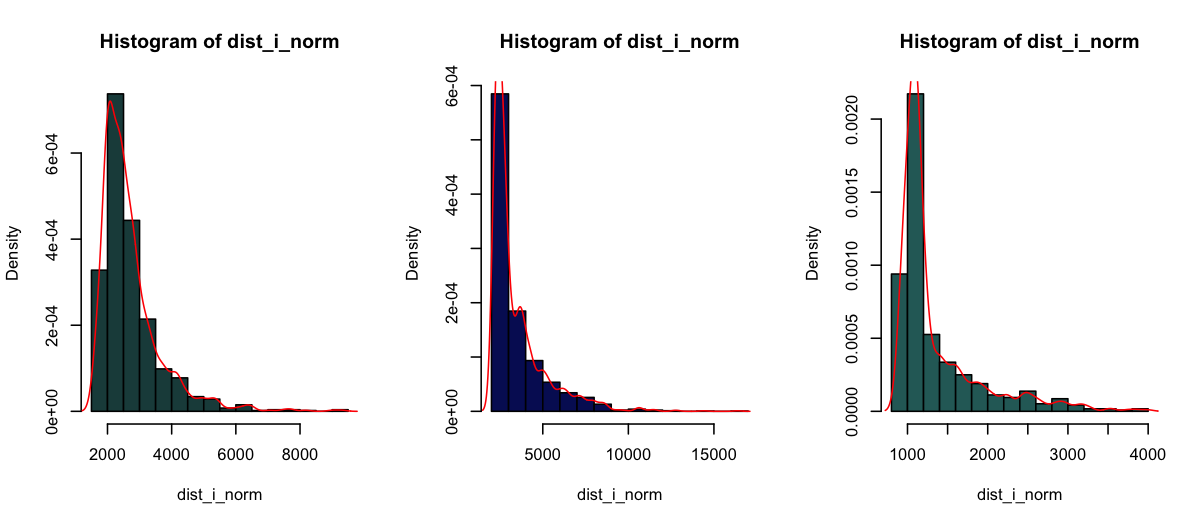

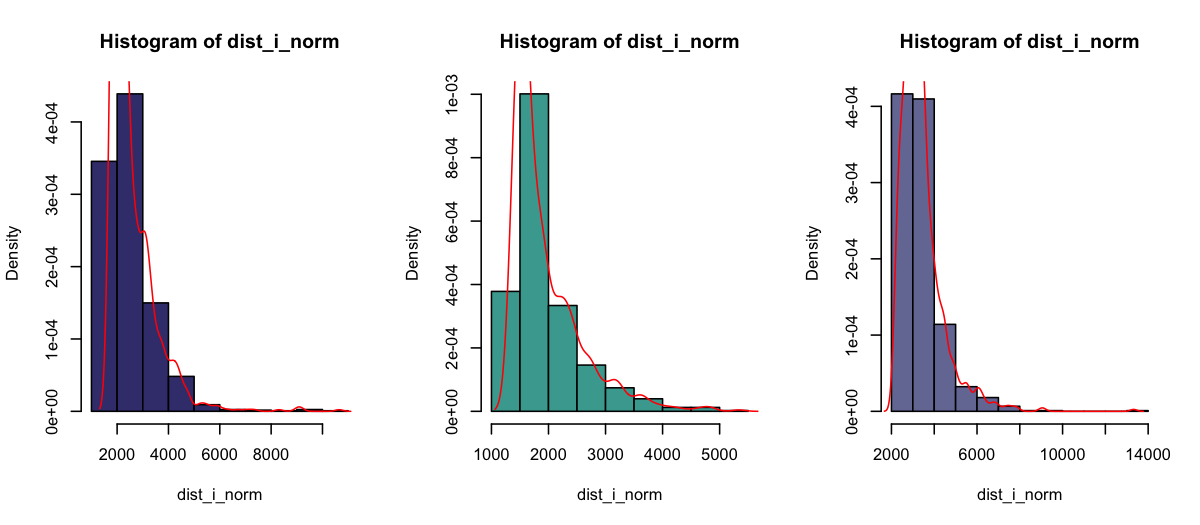

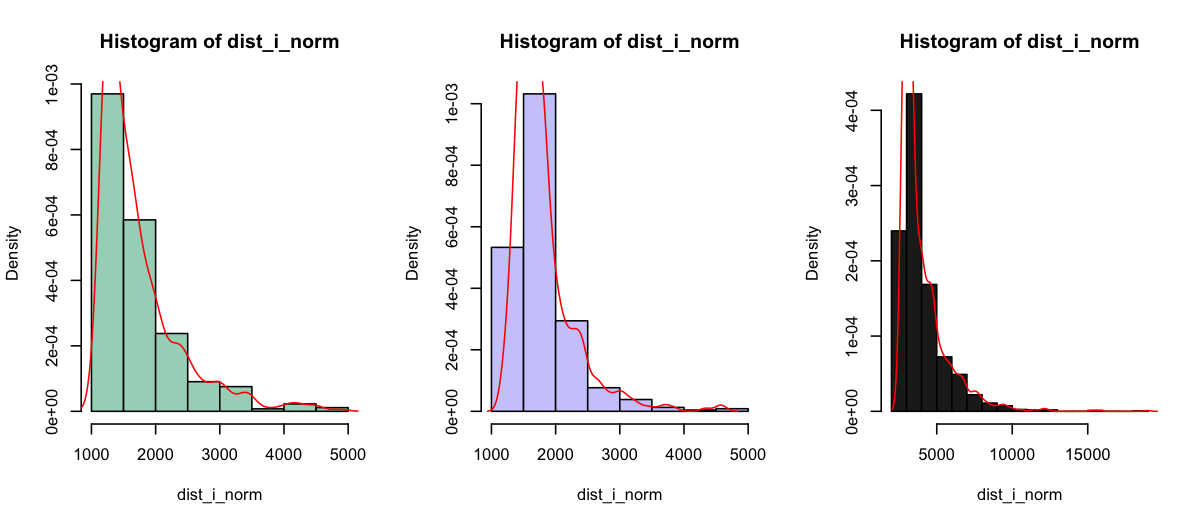

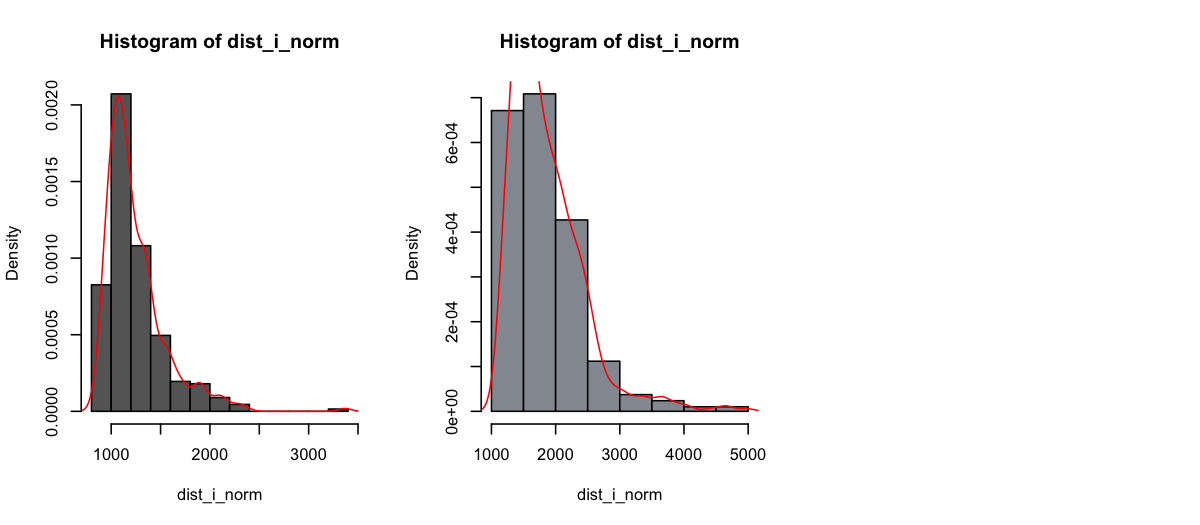

In [81]:
%%R -w 8 -h 3.5 --units in -r 150
par(mfrow = c(1,2))

dist <- read.csv("Data/dist_clust_norm.csv", sep = ",")

for(i in seq(1, nb_clust)) {

dist_i <- subset(dist, clust == i)
    
dist_i_norm <- dist_i$dist
hist(dist_i_norm, col = clusters_col[i], freq = F) ; lines(density(dist_i_norm), col = "Red")
plot(ecdf(dist_i), verticals = TRUE, do.points = FALSE)
curve(pnorm(x, mean(dist_i_norm), sd=sd(dist_i_norm)), col= "red", add = TRUE)
#qqnorm(dist_i_norm)
#qqline(dist_i_norm, col = "red")
}

## 2.8 Schémas fréquents des clusters <a class="anchor" id="2-8"></a>

In [67]:
for k in sorted(seq_emd_clust.keys()) : 
    print("--- Cluster", k,"---\n")
    D = dict()
    for i in range(14) : 
        D[i] = 0
    for i in seq_emd_clust[k] :
        D[daily_pattern(seq_emd[i-1])] += 1
    print(D)
    print("\n")

--- Cluster 1 ---

{0: 33, 1: 117, 2: 144, 3: 33, 4: 120, 5: 126, 6: 47, 7: 60, 8: 27, 9: 48, 10: 8, 11: 94, 12: 99, 13: 99}


--- Cluster 2 ---

{0: 743, 1: 327, 2: 216, 3: 64, 4: 119, 5: 39, 6: 8, 7: 20, 8: 10, 9: 13, 10: 33, 11: 92, 12: 40, 13: 31}


--- Cluster 3 ---

{0: 468, 1: 38, 2: 41, 3: 4, 4: 7, 5: 9, 6: 1, 7: 0, 8: 0, 9: 0, 10: 11, 11: 1, 12: 0, 13: 0}


--- Cluster 4 ---

{0: 591, 1: 183, 2: 189, 3: 20, 4: 72, 5: 39, 6: 15, 7: 7, 8: 6, 9: 7, 10: 17, 11: 34, 12: 18, 13: 3}


--- Cluster 5 ---

{0: 432, 1: 122, 2: 119, 3: 17, 4: 35, 5: 24, 6: 4, 7: 4, 8: 5, 9: 7, 10: 14, 11: 17, 12: 5, 13: 4}


--- Cluster 6 ---

{0: 35, 1: 394, 2: 43, 3: 41, 4: 136, 5: 34, 6: 82, 7: 34, 8: 27, 9: 13, 10: 26, 11: 64, 12: 63, 13: 60}


--- Cluster 7 ---

{0: 5, 1: 162, 2: 8, 3: 1, 4: 73, 5: 6, 6: 26, 7: 17, 8: 13, 9: 5, 10: 8, 11: 103, 12: 64, 13: 39}


--- Cluster 8 ---

{0: 0, 1: 25, 2: 2, 3: 0, 4: 36, 5: 4, 6: 36, 7: 36, 8: 25, 9: 5, 10: 0, 11: 34, 12: 78, 13: 188}


--- Cluster 9 ---

{0:

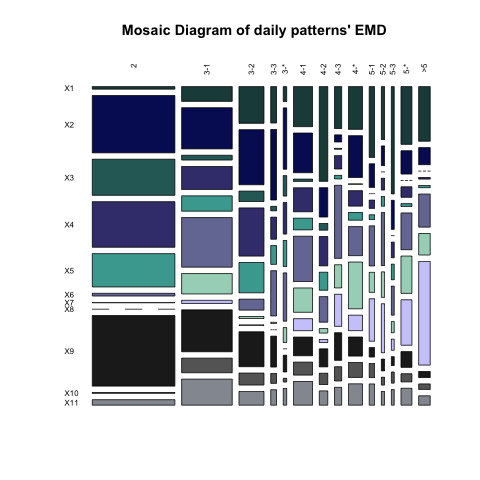

In [68]:
%%R

exdf <- read.table("Data/daily_pattern_clust_table.csv", sep=";", header=T, row.names=1)
extbl <- as.table(as.matrix(exdf))

mosaicplot(extbl,
           col = clusters_col,
           las =2,
           shade = F,
           main = "Mosaic Diagram of daily patterns' EMD")

## 2.9 Extraction des règles des clusters par arbre de décision <a class="anchor" id="2-9"></a>

In [69]:
########################################
# CRÉATION DES VARIABLES CATÉGORIELLES #
########################################

df_act = pd.DataFrame()
act_col = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
label_agg = ["Act: home", "Act: work", "Act: shop", "Act: study", "Act: other", "Act: leasure", "Act: commute", "Act: ?",
             "Move: car", "Move: smooth", "Move: other", "Move: public"]

d_act = dict()


def discret_label(l, c):
    if(l == "Act: home") :
        if(c < 2) :
            return "Nul"
        elif(c == 2) :
            return "Normal"
        else :
            return "Beaucoup"
    if(l in ["Act: work", "Act: shop", "Act: study", "Act: other", "Act: leasure", "Act: commute", "Act: ?"]) :
        if(c == 0) :
            return "Nul"
        elif(c == 1) :
            return "Normal"
        else :
            return "Beaucoup"
    else :
        if(c == 0) :
            return "Nul"
        elif(c == 1) :
            return "Peu"
        elif(c == 2) :
            return "Normal"
        else :
            return "Beaucoup"


for k in sorted(seq_emd_clust.keys()) : 
    for i in seq_emd_clust[k] :
        for l in label_agg: 
            d_act[l] = 0
        for s in seq_emd_agg[i-1]  :
            d_act[s] += 1
        label_discret = [discret_label(key, d_act[key]) for key in d_act.keys()]
        cols = ["X"+str(i), k]+label_discret+[daily_pattern(seq_emd[i-1]), "faible" if len(seq_emd[i-1])/delta(seq_emd[i-1]) < 2 else "forte"]
        act_col = append_col(act_col, cols)
        
df_act["id_seq"] = act_col[0]
df_act["id_clust"] = act_col[1]
df_act["home"] = act_col[2]
df_act["work"] = act_col[3]
df_act["shop"]  = act_col[4]
df_act["study"] = act_col[5]
df_act["other"] = act_col[6]
df_act["leasure"] = act_col[7]
df_act["commute"] = act_col[8]
df_act["?"] = act_col[9]
df_act["car"] = act_col[10]
df_act["smooth"] = act_col[11]
df_act["other"] = act_col[12]
df_act["public"] = act_col[13]
df_act["daily_pattern"] = act_col[14]
df_act["reg"] = act_col[15]

print(df_act)

df_act.to_csv(r"decision.csv", index=False)

      id_seq  id_clust      home      work    shop     study other   leasure  \
0        X27         1  Beaucoup    Normal     Nul       Nul   Nul    Normal   
1        X31         1    Normal    Normal     Nul       Nul   Nul       Nul   
2        X39         1  Beaucoup       Nul  Normal       Nul   Nul       Nul   
3        X81         1    Normal    Normal     Nul       Nul   Nul       Nul   
4        X91         1  Beaucoup  Beaucoup  Normal       Nul   Nul       Nul   
...      ...       ...       ...       ...     ...       ...   ...       ...   
10000  X9859        11    Normal       Nul     Nul    Normal   Nul       Nul   
10001  X9919        11    Normal       Nul     Nul  Beaucoup   Nul       Nul   
10002  X9966        11  Beaucoup       Nul     Nul    Normal   Nul  Beaucoup   
10003  X9980        11  Beaucoup       Nul     Nul    Normal   Nul    Normal   
10004  X9983        11    Normal       Nul     Nul  Beaucoup   Nul    Normal   

        commute    ?       car    smoot

In [3]:
%%R

data <- read.csv("Data/decision.csv", sep = ",")

data <- data[,-1] # Suppression des ids
data$id_clust <- as.factor(data$id_clust)
data$daily_pattern <- as.factor(data$daily_pattern)
glimpse(data)

n_row = nrow(data)
data_shuffle <- data[sample(n_row),]
size <- 0.8 # Taille du train dataset

total_row = size * n_row
train_sample <- 1:total_row
data_train <- data_shuffle[train_sample, ]
data_test <- data_shuffle[-train_sample, ]


dim(data_train)
prop.table(table(data_train$id_clust))


Observations: 10,005
Variables: 14
$ id_clust      <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ home          <fct> Beaucoup, Normal, Beaucoup, Normal, Beaucoup, Normal,...
$ work          <fct> Normal, Normal, Nul, Normal, Beaucoup, Normal, Normal...
$ shop          <fct> Nul, Nul, Normal, Nul, Normal, Nul, Nul, Nul, Nul, Nu...
$ study         <fct> Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul...
$ other         <fct> Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul...
$ leasure       <fct> Normal, Nul, Nul, Nul, Nul, Normal, Nul, Nul, Normal,...
$ commute       <fct> Normal, Beaucoup, Normal, Normal, Normal, Normal, Bea...
$ X.            <fct> Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul...
$ car           <fct> Beaucoup, Beaucoup, Beaucoup, Beaucoup, Beaucoup, Bea...
$ smooth        <fct> Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul, Nul...
$ public        <fct> Nul, Nul, Nul, Nul, Beaucoup, Nul, Nul, Nul, Nul, Nul...
$ daily_pattern <

In [6]:
%%R

fit <- rpart(id_clust~., data = data_train,
             method = 'class',
             control = rpart.control(cp = 0.04),
             parms = list(split = "information"))

pdf("decision_tree.pdf", width = 8, height = 8)
rpart.plot(fit)
#plotcp(fit)
#t_opt <- prune(fit,cp=fit$cptable[which.min(fit$cptable[,4]),1])


In [5]:
%%R

predict_unseen <-predict(fit, data_test, type = 'class')
table_mat <- table(data_test$id_clust, predict_unseen)
table_mat

    predict_unseen
       1   2   3   4   5   6   7   8   9  10  11
  1  183   0   0   0   0   0   0   7   0   0   0
  2   10 353   0   0   0   4   0   0   0   0   0
  3    1  28  83   4   2   0   0   0   1   0   0
  4    7   5   0 204   9   4   0   0   0   0   0
  5   14   0   0  40  90   0   0   0   0   0   1
  6    2   0   0   1   0 184   0  10   0   0  18
  7    0   1   0   0   0 102   0   6   1   0   1
  8    5   0   0   0   0   1   0  80   0   0   0
  9    0   0   0   0   0   1   0   0 339   0   0
  10   0   0   2   0   0   6   0   1  58   0   1
  11   0   0   0   0   0   0   0   0  16   0 115
